# Shlukování

 V tomto notebooku si budeme hrát se shlukováním.
 
 * Nejprve si na umělých datech vyzkoušíme hierarchické shlukování a algoritmus k-means, abychom si obě metody osahali.
 * Potom provedeme hierarchické shlukování na datasetu Iris (3 druhy kosatců) a podíváme se jak nalezené shluky odpovídají reálným druhům.
 * Nakonec se podíváme na vektorovou kvantizaci obrázků jakožto zajímavou aplikaci algoritmu k-means.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

np.set_printoptions(precision=5, suppress=True)  # potlačení výpisu floatů (tak aby 0.000 bylo zobrazeno jako 0.)

## Umělá data - hierarchické shlukování & algoritmus k-means

### Generování umělých dat

Umělá data vygenerujeme jako náhodné výběry ze tří růzých vícerozměrných normálních rozdělení, které následně spojíme.

Parametry vícerozměrného normálního rozdělení jsou (stručně):
* Vektor středních hodnot - odpovídá středu výsledného shluku.
* Varianční matice - odpovídá tvaru (kruh nebo nějakým způsobem natočená elipsa) a velikosti vygenerovaného shluku.

(120, 2)


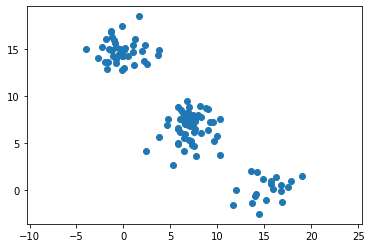

In [11]:
# generování tří shluků: a se 60 body, b se 40 body, c s 20:
np.random.seed(50)  # zajistí replikovatelnost

a = np.random.multivariate_normal([7, 7], [[2, 0.5], [0.5, 2]], size=[60,])
b = np.random.multivariate_normal([0, 15], [[2, 0], [0, 2]], size=[40,])
c = np.random.multivariate_normal([15, 0], [[3, 1], [1, 4]], size=[20,])

# spojení shluků do X
X = np.concatenate((a, b, c),)

# zobrazení velikosti výsledných dat
print(X.shape)

# zobrazení výsledných dat
plt.scatter(X[:,0], X[:,1])
plt.axis('equal')
plt.show()

### Aglomerativní hierarchické shlukování

Použijeme knihovnu `scipy` a konkrétně sekci hierarchického shlukování. [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html).

Tato část notebooku je inspirována [tímto příspěvkem na blogu](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/).

#### Nejprve vytvořme dendrogram
Použijeme funkci `linkage` [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage).
* Důležitým argumentem je volba metody,kterou se měří vzdálenosti shluků.
* Nyní použijeme metodu nejbližšího souseda (single linkage). Později si můžete hrát i s těmi ostatními - complete linkage / average linkage / wardova metoda.

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage

# spočteme tzv. matici propojení
Z = linkage(X, 'single')

# rozměry výstupu
print(Z.shape)

(119, 4)


Výstupem je matice propojení (linkage matrix),ve které každý řádek odpovídá jednomu spojení shluků do nového shluku. 
Sloupce jsou:
* index prvního spojovaného shluku
* index druhého spojovaného shluku
* vzdálenost mezi spojovanými shluky
* počet bodů, které jsou v nově vytvořeném shluku

In [13]:
# Podívejme se na prvních 5 řádků Z
print(Z[:5,:])

# obvzláště si všimněte třetího řádku, kde má jeden ze spojovaných shluků index 120, 
# což je ve skutečnosti první shluk vytvořený spojením.

[[ 29.       53.        0.05081   2.     ]
 [ 11.       51.        0.05374   2.     ]
 [ 42.      120.        0.06651   3.     ]
 [ 14.       20.        0.10288   2.     ]
 [  5.       57.        0.11794   2.     ]]


#### Vizualizace dendrogramu
Použijeme funkci `dendrogram` [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram).

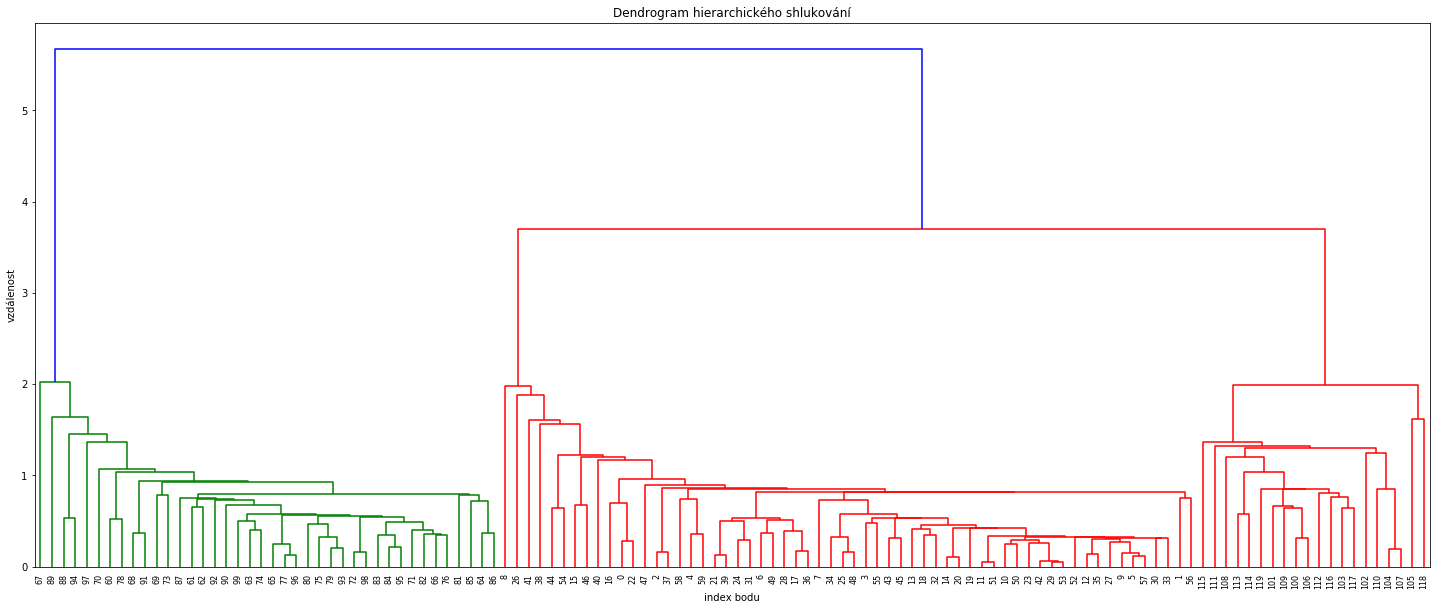

In [14]:
# výpočet plného dendrogramu
plt.figure(figsize=(25, 10))
plt.title('Dendrogram hierarchického shlukování')
plt.xlabel('index bodu')
plt.ylabel('vzdálenost')
dendrogram(
    Z,
    leaf_rotation=90.,  # otočení popisů x-ové osy
    leaf_font_size=8.,  # velikost fontu popisů x-ové osy
)
plt.show()

Všimněte si, že:
* horizontální čáry odpovídají spojením shluků
* vertikální čáry nám říkají, které shluky se do nového shluku spojují
* výšky (tj. y-ové pozice) horizontálních čar odpovídají vzdálenosti mezi spojovanými shluky

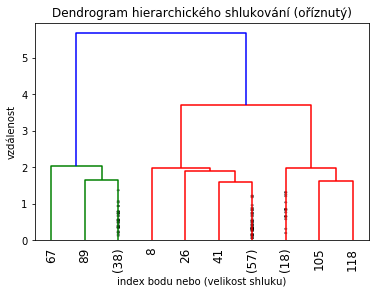

In [15]:
# Můžeme také zobrazit pouze horní část dendrogramu, kde dochází ke spojování posledních velkých shluků
plt.title('Dendrogram hierarchického shlukování (oříznutý)')
plt.xlabel('index bodu nebo (velikost shluku)')
plt.ylabel('vzdálenost')
dendrogram(
    Z,
    truncate_mode='lastp',  # Zobraz jenom posledních p spojených shluků
    p=10,  # Nastavení toho p
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # pomáhá vizuální představě o spojování vedoucí k těm uříznutým shlukům 
    # (čárky na spodních vertikálních čárách).
)
plt.show()

#### Fancy verze vykreslení dendrogramu
S využitím: [annotating the distances inside the dendrogram](https://stackoverflow.com/questions/11917779/how-to-plot-and-annotate-hierarchical-clustering-dendrograms-in-scipy-matplotlib/12311618#12311618)

In [16]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Dendrogram hierarchického shlukování (oříznutý)')
        plt.xlabel('index bodu nebo (velikost shluku)')
        plt.ylabel('vzdálenost')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

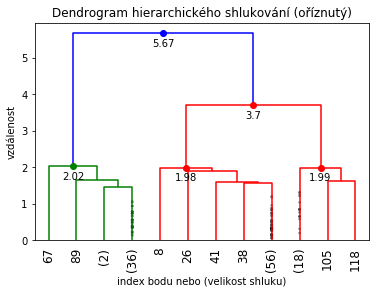

In [17]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1.9,  # výhodné u malých obrázků, aby se to nepřekrývalo
)
plt.show()

## Extrakce shlukování z dendrogramu
K tomu využijeme funkci `fcluster` [(dokumentace zde)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster).

#### Pokud známe výšku řezu
t.j. hranici pro vzdálenost shluků nad kterou už nebudeme spojovat.

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]


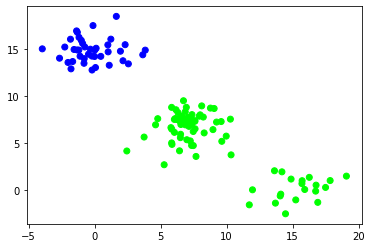

In [35]:
from scipy.cluster.hierarchy import fcluster
max_d = 5
clusters = fcluster(Z, max_d, criterion='distance')
# výpis shlukování
print(clusters)

# Vizualizace
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='brg')  # plot points with cluster dependent colors
plt.show()

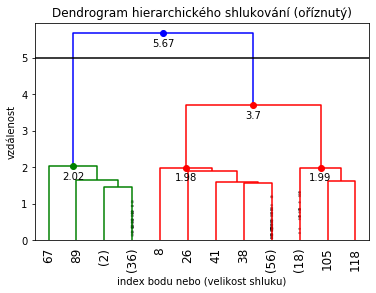

In [19]:
# Vizualizace řezu v dendrogram
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1.9,
    max_d = max_d,
)
plt.show()

#### Jestliže známe požadovaný počet shluků $k$

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3]


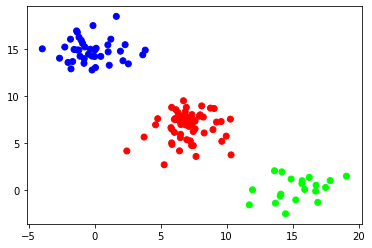

In [20]:
k = 3
clusters = fcluster(Z, k, criterion='maxclust')
# výpis shlukování
print(clusters)

# Obrázek
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='brg')  # plot points with cluster dependent colors
plt.show()

### Algoritmus $k$-means 
Použijeme sekci `clustering` z knihovny `sklearn` [(dokumentace zde)](http://scikit-learn.org/stable/modules/clustering.html#k-means).

Konkrétně použijeme funkci `Kmeans` [(dokumentace zde)](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
[[ 9.13007  5.12392]
 [-0.18957 14.84594]]


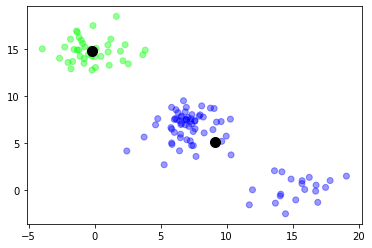

In [55]:
from sklearn.cluster import KMeans

# Nejdřív zkusme 2 shuky
k = 2
kmeans = KMeans(n_clusters = k, random_state = 1).fit(X)

# výsledné shluky
print(kmeans.labels_)
# a jejich středy
print(kmeans.cluster_centers_)

# Vizualizace
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'black', s=100)
plt.show()

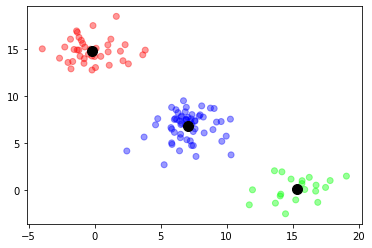

In [47]:
# To stejné pro 3shluky
k = 3
kmeans = KMeans(n_clusters = k, random_state = 1).fit(X)

# Vizualizace
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'black', s=100)
plt.show()

V defaultním nastavení probíhá inicializace středů "chytrým" způsobem, `init = 'k-means++'` [David, Vassilvitskii (2007)](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf), a běh algoritmu se opakuje 10 krát, `n_init = 10`.

Finálním výstupem je pak výstup nějlepšího běhu (nejmenší hodnota účelové funkce výsledku).

Kromě této "chytré" inicializace je možné použít klasickou náhodnou inicializaci (náhodný výběr z dat) nebo dokonce určit počáteční středy manuálně.

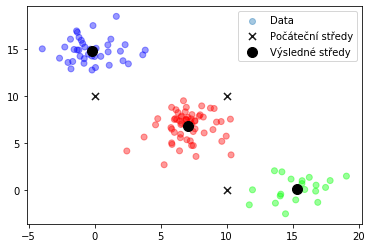

In [71]:
k = 3
# manuální inicializace
initial_centers = np.array([[0,10],[10,10],[10,0]])

# shlukování
kmeans = KMeans(n_clusters = k, random_state = 1, init = initial_centers, n_init = 1).fit(X)

# Vizualizace
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
plt.scatter(initial_centers[:,0], initial_centers[:,1], c = 'black', s=50, alpha = 0.9, marker = 'x') # initial centers
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = 'black', s=100) # final centers
plt.legend(['Data', 'Počáteční středy', 'Výsledné středy'])
plt.show()

### Algoritmus $k$-means můžeme z důvodu "osahání" jednoduše implementovat ručně

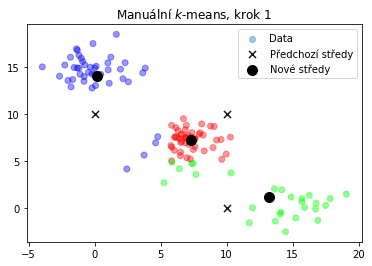

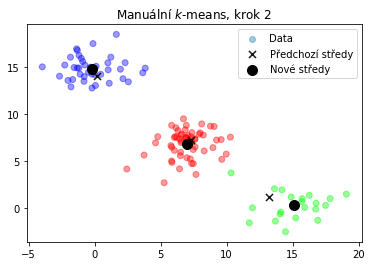

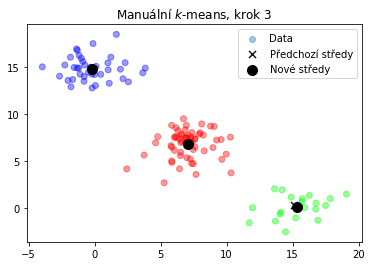

In [72]:
from sklearn.metrics import pairwise_distances_argmin
centers = initial_centers
for i in range(3):
    y_pred = pairwise_distances_argmin(X, centers)
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(len(centers))])

    # Obrázek
    plt.scatter(X[:,0], X[:,1], c=y_pred, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
    plt.scatter(centers[:,0], centers[:,1], c = 'black', s=50, alpha = 0.9, marker = 'x') # old centers
    plt.scatter(new_centers[:,0], new_centers[:,1], c = 'black', s=100) # new centers
    plt.title('Manuální $k$-means, krok ' + str(i+1))
    plt.legend(['Data', 'Předchozí středy', 'Nové středy'])
    plt.show()
    
    centers = new_centers

### Určování optimální hodnoty $k$
Zobrazíme hodnotu účelové funkce vzávislosti na $k$ a budeme hledat bod zlomu (loket).

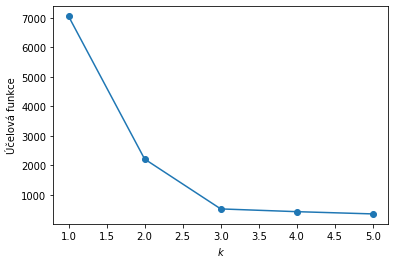

In [25]:
ix = np.zeros(5)
iy = np.zeros(5)
for k in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(X)
    iy[k] = kmeans.inertia_
    ix[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(ix, iy, 'o-')
plt.show()

## Úkol 1 - proveďte hierarchické shlukování na Iris datasetu
* Hledejte 3 shluky
* Diskutujte a kvantifikujte vhodným způsobem kvalitu výsledných shluků ve vztahu ke skutečným druhým kosatců (Setosa, Versicolour a Virginica), které jsou uložené vproměnné y.
* Zkuste najít nejlepší metodu měření vzdáleností shluků, aby získané shluky nejvíce odpovídaly skutečným druhům kosatců.

In [74]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

print('X shape:', X.shape)

X shape: (150, 4)


In [ ]:
## Váš kód napište sem


### Úkol 2 - proveďte vektorovou kvantizaci obrázku pomocí algoritmu $k$-means
Je třeba instalovat balíček Pillow
`pip install Pillow`. [(dokumentace zde)](https://pillow.readthedocs.io/en/5.3.x/index.html)

Nejprve úvodní část kódu, která nás dovede na začátek vlastního problému.

Shape of the array: (341, 512)


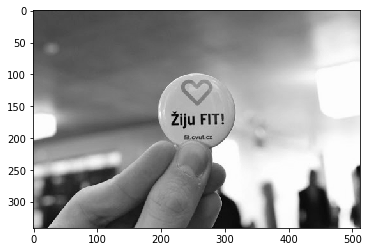

In [75]:
from PIL import Image
# otevření a převedení do stupňů šedi
im = Image.open("figure.jpg").convert("L")
# normalizace numpy array na čísla mezi 0 a 1
pix = np.array(im)/255.0
print('Shape of the array:', pix.shape)
# Zobrazení
plt.imshow(pix, cmap="gray", clim=(0, 1));
plt.show()

Vlastní úkol:
* ořízněte obrázek tak, aby jeho šířka byla násobkem 4
* vytvořte sloupcové bločky délky 4 - tj. části z originálního obrázku s rozměry (1,4).
* proveďte shlukování pomocí k-means s k = 255 shluky - tj. bude stačit jeden bajt na přenesení informace o příslušnosti ke shluku
* extrahujte středy bloků a labely - tj. indexy příslušnosti originálních bločků k jednotlivým shlukům
* dekódujte je zpět do pole s rozměrem originálního obrázku - **hint** - využijte: `restored = np.take(centroids, labels, axis = 0)`
* zobrazte výsledek
* diskutujte redukci velikost pokud použijeme reprezentaci původního obrázku pomocí středů a labelů.

In [ ]:
## Váš kód napište sem
